In [1]:
import os

# this allows for parallelization with pmap.
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(500)
import jax
import jax.numpy as jnp
import sys
sys.path.append('../src/')

from nn import MLP, train
import numpy as np
import matplotlib.pyplot as plt
import optax 
import scipy
from functools import partial
from path_sampling import dfdt, div_f, update_non_amortized
from path_sampling import make_double_well_potential, sample_sde


## Example of Algorithm 1: with $b = -\nabla V$ for double well potenetial, and we condition on the end point

This is an instance of prior -> posterior transport.



In [2]:
potential = make_double_well_potential(v=5.0)

def uref(x, t): 
    return -jax.grad(potential)(x)


s:  0.0
Train loss: 1104384.75
s:  0.0
Train loss: 931799.625
s:  0.1
Train loss: 1746565.5
s:  0.2
Train loss: 667905.875
s:  0.30000000000000004
Train loss: 29779.740234375
s:  0.4
Train loss: 9303.8046875
s:  0.5
Train loss: 9129.1982421875
s:  0.6000000000000001
Train loss: 6150.99560546875
s:  0.7000000000000001
Train loss: 6473.54052734375
s:  0.8
Train loss: 5656.20458984375
s:  0.9
Train loss: 3855.057861328125


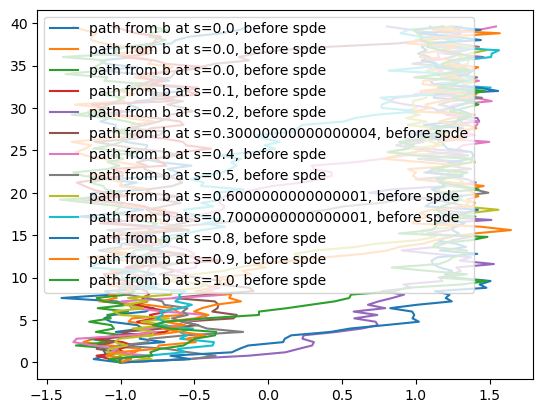

In [4]:
key = jax.random.key(0)
schedule = np.linspace(0,1,11)


# currently we're just doing an SDE on \mathbb{R}
ndims = 1

b = lambda x, t: -jax.grad(make_double_well_potential(v=5.0))(x)  # b = -\nabla V
A_TH = 0


for i, s in enumerate(schedule):


    key = jax.random.fold_in(key, i)

    nn_key, run_key = jax.random.split(key)
    dbds = MLP([3,30,20,10,1], key=nn_key)
    
    # update b -> b + dbds
    b, A = update_non_amortized(
        V=make_double_well_potential(v=5.0),
        b=b,
        J=lambda x,y: (1/2.0)*(1/0.1**2)*(x[-1,0]- 1)**2,   # condition on hitting x(T)=+1
        dbds=dbds,
        hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 250, 'batch_size' :500},
        key=key,
        schedule=schedule,
        i=i,
        prior='sde_prior',
        A_TH=A_TH,
        rho = lambda key: jnp.zeros((1,))-1.,   # initialize at -1
        refine=False,
        ndims=ndims
    )

## Rerun Algorithm 1 with SPDE turned on

s:  0.0


OpenBLAS warning: precompiled NUM_THREADS exceeded, adding auxiliary array for thread metadata.


Train loss: 1030173.9375
s:  0.0
Train loss: 816721.125
s:  0.1
Train loss: 304409.03125
s:  0.2
Train loss: 78789.875
s:  0.30000000000000004
Train loss: 34765.5
s:  0.4
Train loss: 14665.8505859375
s:  0.5
Train loss: 8819.6123046875
s:  0.6000000000000001
Train loss: 5836.02294921875
s:  0.7000000000000001
Train loss: 4959.9599609375
s:  0.8
Train loss: 3641.22607421875
s:  0.9
Train loss: nan


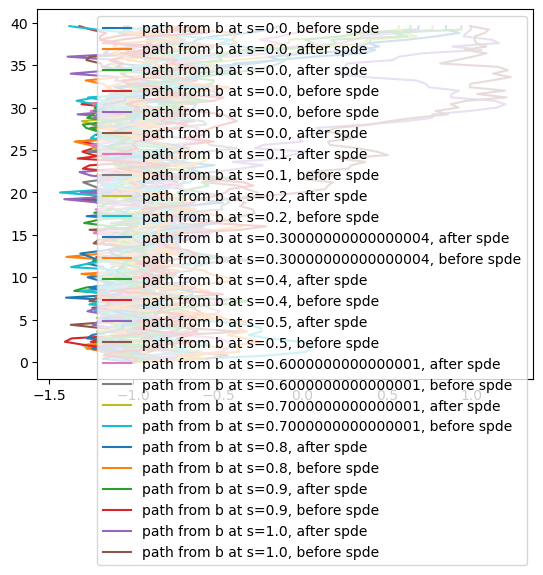

In [3]:
key = jax.random.key(0)
schedule = np.linspace(0,1,11)


# currently we're just doing an SDE on \mathbb{R}
ndims = 1

b = lambda x, t: -jax.grad(make_double_well_potential(v=5.0))(x)  # b = -\nabla V
A_TH = 0


for i, s in enumerate(schedule):


    key = jax.random.fold_in(key, i)

    nn_key, run_key = jax.random.split(key)
    dbds = MLP([3,30,20,10,1], key=nn_key)
    
    # update b -> b + dbds
    b, A = update_non_amortized(
        V=make_double_well_potential(v=5.0),
        b=b,
        J=lambda x,y: (1/2.0)*(1/0.1**2)*(x[-1,0]- 1)**2,   # condition on hitting x(T)=+1
        dbds=dbds,
        hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 250, 'batch_size' :500},
        key=key,
        schedule=schedule,
        i=i,
        prior='sde_prior',
        A_TH=A_TH,
        rho = lambda key: jnp.zeros((1,))-1.,   # initialize at -1
        refine=True,   # parameters: 1e-4, 200
        ndims=ndims
    )
    